<a href="https://colab.research.google.com/github/Umakantamaharana/weeds_classification/blob/main/Weeds_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deepweeds

## Preparing deepweed dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir /root/.kaggle

In [ ]:
!cp drive/MyDrive/kaggle.json /root/.kaggle/

In [ ]:
!kaggle datasets download -d imsparsh/deepweeds

In [ ]:
!unzip deepweeds.zip

## Installing requirements

In [ ]:
!pip install fastai timm

In [ ]:
from fastai.vision.all import *
set_seed(42)

# Specify the path to the dataset or images directory
path = Path('images')  # Change this path to the appropriate location if needed

# List the contents of the path
path.ls()

In [ ]:
trn_path = path
files = get_image_files(trn_path)
tst_path = path

## Viewing the data

(256, 256)


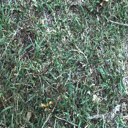

In [ ]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [ ]:
from fastcore.parallel import *
def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=64)
pd.Series(sizes).value_counts()

(256, 256)    17509
dtype: int64

In [ ]:
data_df=pd.read_csv('labels/labels.csv')

In [ ]:
data_df['path']=data_df['Filename'].apply(lambda x:os.path.join(trn_path,x))
data_df=data_df.drop(['Filename','Label'],axis=1)
display(data_df)
display(data_df['Species'].value_counts())

,Species,path
0,Chinee apple,images/20160928-140314-0.jpg
1,Chinee apple,images/20160928-140337-0.jpg
2,Chinee apple,images/20160928-140731-0.jpg
3,Chinee apple,images/20160928-140747-0.jpg
4,Chinee apple,images/20160928-141107-0.jpg
...,...,...
17504,Negative,images/20180322-133822-1.jpg
17505,Negative,images/20180322-133832-1.jpg
17506,Negative,images/20180322-133840-1.jpg
17507,Negative,images/20180322-133850-1.jpg


Negative          9106
Chinee apple      1125
Siam weed         1074
Lantana           1064
Prickly acacia    1062
Parkinsonia       1031
Parthenium        1022
Snake weed        1016
Rubber vine       1009
Name: Species, dtype: int64

No charts were generated by quickchart


In [ ]:
m=len(data_df)
M=list(range(m))
random.seed(2021)
random.shuffle(M)
train_df=data_df.iloc[M[0:(m//5)*4]]
test_df=data_df.iloc[M[(m//5)*4:]]

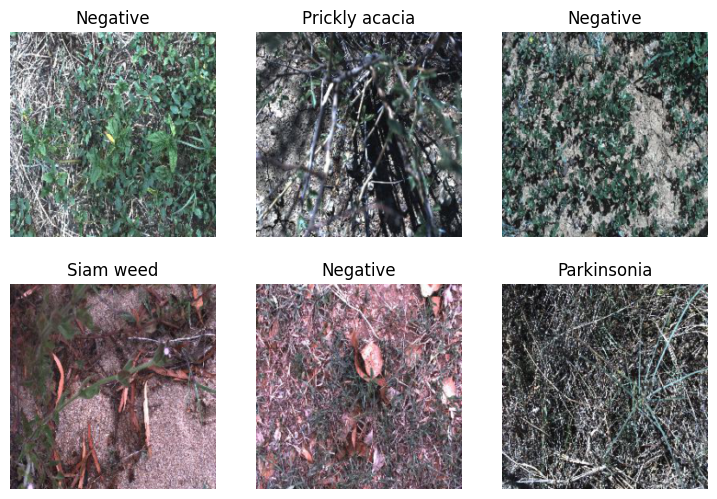

In [ ]:
#ImageDataLoaders.from_df
dls = ImageDataLoaders.from_df(train_df,
                               fn_col=1, #path
                               label_col=0, #Species
                               folder='',
                               valid_pct=0.2,
                               item_tfms=Resize(224))
dls.show_batch(max_n=6)

## Training

In [ ]:
# models_um = ['densenet169', 'vgg16_bn', 'resnet26']
# models_gvsnarayana = ['densenet201', 'vgg19_bn', 'resnet152']

In [ ]:
learn = vision_learner(dls, vgg16_bn, metrics=error_rate, path='.').to_fp16()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0014454397605732083, slide=0.00363078061491251)

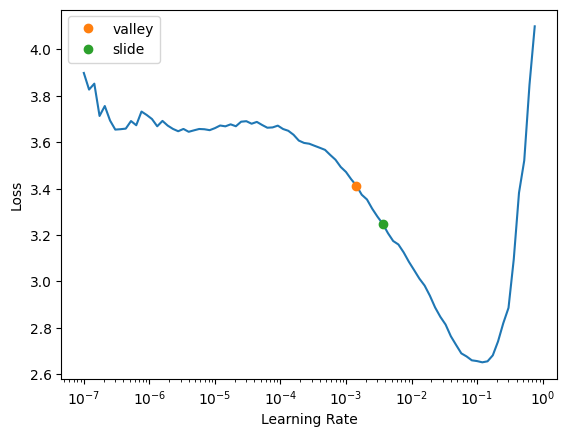

In [ ]:
learn.lr_find(suggest_funcs=(valley, slide))

In [ ]:
learn.fine_tune(50,0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.066116,0.702450,0.229286,01:32


epoch,train_loss,valid_loss,error_rate,time
0,0.402290,0.304391,0.103214,01:56
1,0.123462,0.267593,0.085714,01:54
2,0.081476,0.351119,0.102500,01:55
3,0.108976,0.383856,0.100000,01:55
4,0.113832,0.409302,0.111071,01:55
5,0.128764,0.468587,0.113571,01:54
6,0.135892,0.519413,0.130000,01:56
7,0.141102,0.327399,0.087500,01:54
8,0.162828,0.392518,0.108214,01:56
9,0.154705,0.569183,0.127857,01:56


In [ ]:
learn.export('/content/drive/MyDrive/mvgg16_bn.pkl', pickle_protocol=2)
# learn.save_state_dict('/content/drive/MyDrive/vgg16_bn_d.pth')
# learn.save('/content/drive/MyDrive/vgg16_bn')

## Testing

In [ ]:
from fastai.learner import load_learner

# Load the Learner object from the file
learn1 = load_learner('/content/drive/MyDrive/mvgg16_bn.pkl', pickle_protocol=2)
# learn1 = learn1.to_fp16()
# learn1.model = learn1.model.to('cuda')

# learn.export (fname='export.pkl', pickle_protocol=2)
# learn1 = load_learner ('export.pkl', cpu=False)

TypeError: ignored

In [ ]:
tst_dl = dls.test_dl(test_df)
# tst_files = get_image_files(tst_path).sorted()
# tst_dl = dls.test_dl(tst_files)
# print(tst_files[0:3])

In [ ]:
len(tst_files)

NameError: ignored

In [ ]:
probs,_,idxs = learn1.get_preds(dl=tst_dl, with_decoded=True)

In [ ]:
normal_mapping = dict(enumerate(dls.vocab))
print(normal_mapping)
reverse_mapping=dict(zip(dls.vocab,list(range(len(dls.vocab)))))
print(reverse_mapping)

In [ ]:
results = pd.Series(idxs.numpy(),name="idxs")
display(results)
testY=test_df['Species'].map(reverse_mapping)
display(testY)

0       2
1       2
2       3
3       2
4       2
       ..
3500    2
3501    8
3502    7
3503    2
3504    2
Name: idxs, Length: 3505, dtype: int64

17447    2
11091    2
6611     3
9755     2
11015    2
        ..
14531    2
1135     8
8104     7
9067     2
13245    2
Name: Species, Length: 3505, dtype: int64

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(testY,idxs,target_names=dls.vocab,digits=4))

                precision    recall  f1-score   support

  Chinee apple     0.9591    0.8866    0.9214       238
       Lantana     0.9567    0.9522    0.9544       209
      Negative     0.9576    0.9813    0.9693      1820
   Parkinsonia     0.9775    0.9508    0.9640       183
    Parthenium     0.9713    0.9531    0.9621       213
Prickly acacia     0.9317    0.9317    0.9317       205
   Rubber vine     0.9682    0.9595    0.9638       222
     Siam weed     0.9764    0.9452    0.9606       219
    Snake weed     0.9362    0.8980    0.9167       196

      accuracy                         0.9586      3505
     macro avg     0.9594    0.9398    0.9493      3505
  weighted avg     0.9587    0.9586    0.9584      3505



In [ ]:
class_labels = []
for classes in normal_mapping.items():
  class_labels.append(classes[1])

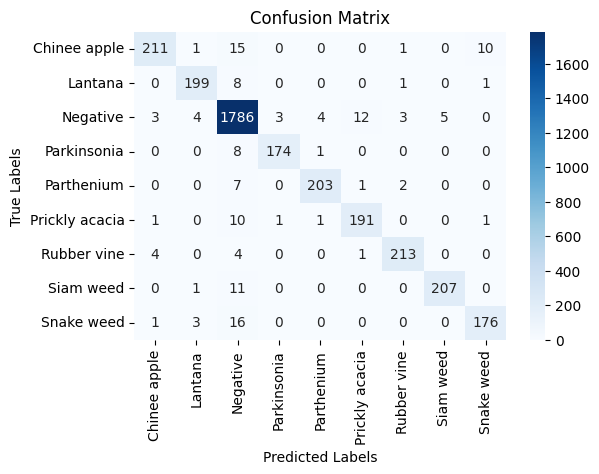

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert class labels to integer indices (assuming you have the reverse_mapping dictionary)
# testY_indices = testY.map(reverse_mapping)

# Get the predictions from the model (assuming you already have 'idxs' from the previous code)
preds_indices = results

# Create the confusion matrix
cm = confusion_matrix(testY, preds_indices)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Testing for a single image

In [ ]:
from PIL import Image

# Load the test image
test_image = Image.open('lantana.jpg')
test_image = test_image.resize((256, 256))

# Create a test dataloader with the same transformations used during training
test_dl = learn.dls.test_dl([test_image])

# Get the predictions from the model
preds, _ = learn.get_preds(dl=test_dl)

# Get the index of the class with the highest probability
predicted_class_idx = preds.argmax()

# Assuming you have a list of class labels
predicted_label = class_labels[predicted_class_idx]

In [ ]:
predicted_label

'Lantana'

#CottonWeed

# Soybeen with Weeds

## Preparing dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /root/.kaggle

In [ ]:
!cp /content/kaggle.json /root/.kaggle/

In [ ]:
!kaggle datasets download -d fpeccia/weed-detection-in-soybean-crops

 99% 2.34G/2.37G [00:25<00:00, 65.9MB/s]
100% 2.37G/2.37G [00:25<00:00, 98.5MB/s]


In [ ]:
!unzip "weed-detection-in-soybean-crops.zip"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/soybean/3137.tif  
  inflating: dataset/soybean/3138.tif  
  inflating: dataset/soybean/3139.tif  
  inflating: dataset/soybean/314.tif  
  inflating: dataset/soybean/3140.tif  
  inflating: dataset/soybean/3141.tif  
  inflating: dataset/soybean/3142.tif  
  inflating: dataset/soybean/3143.tif  
  inflating: dataset/soybean/3144.tif  
  inflating: dataset/soybean/3145.tif  
  inflating: dataset/soybean/3146.tif  
  inflating: dataset/soybean/3147.tif  
  inflating: dataset/soybean/3148.tif  
  inflating: dataset/soybean/3149.tif  
  inflating: dataset/soybean/315.tif  
  inflating: dataset/soybean/3150.tif  
  inflating: dataset/soybean/3151.tif  
  inflating: dataset/soybean/3152.tif  
  inflating: dataset/soybean/3153.tif  
  inflating: dataset/soybean/3154.tif  
  inflating: dataset/soybean/3155.tif  
  inflating: dataset/soybean/3156.tif  
  inflating: dataset/soybean/3157.tif  
  inflating: dataset/soybean/31

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

In [ ]:
!rm -r "/content/dataset/dataset"

## Train, Validate & Test and hyperparameters

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet201, DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Set the path to your original dataset
original_data_dir = '/content/dataset/'

In [ ]:
import os
# Set the path to create the training, validation, and test directories
base_dir = '/content/weedsets/'
os.makedirs(base_dir, exist_ok=True)
# Create the directory structure
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)

validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)

test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

In [ ]:
# Set the ratio for splitting the dataset
train_ratio = 0.7  # 70% for training
validation_ratio = 0.15  # 15% for validation
test_ratio = 0.15  # 15% for testing

In [ ]:
import random
import shutil
# Iterate over the original dataset and move the files
for class_name in os.listdir(original_data_dir):
    class_dir = os.path.join(original_data_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    # Create class directories in the train, validation, and test sets
    train_class_dir = os.path.join(train_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)

    validation_class_dir = os.path.join(validation_dir, class_name)
    os.makedirs(validation_class_dir, exist_ok=True)

    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(test_class_dir, exist_ok=True)

    # Get the list of files in the class directory
    file_list = os.listdir(class_dir)

    # Shuffle the file list randomly
    random.shuffle(file_list)

    # Split the files into training, validation, and test sets based on the ratios
    num_files = len(file_list)
    train_split = int(train_ratio * num_files)
    validation_split = int((train_ratio + validation_ratio) * num_files)

    train_files = file_list[:train_split]
    validation_files = file_list[train_split:validation_split]
    test_files = file_list[validation_split:]

    # Move the files to the respective directories
    for file_name in train_files:
        src = os.path.join(class_dir, file_name)
        dst = os.path.join(train_class_dir, file_name)
        if os.path.isfile(src):
            shutil.copyfile(src, dst)

    for file_name in validation_files:
        src = os.path.join(class_dir, file_name)
        dst = os.path.join(validation_class_dir, file_name)
        if os.path.isfile(src):
            shutil.copyfile(src, dst)

    for file_name in test_files:
        src = os.path.join(class_dir, file_name)
        dst = os.path.join(test_class_dir, file_name)
        if os.path.isfile(src):
            shutil.copyfile(src, dst)

In [ ]:
# Set the paths to your dataset
train_data_dir = '/content/weedsets/train'
validation_data_dir = '/content/weedsets/validation'
test_data_dir = '/content/weedsets/test'

In [ ]:
import os
original_data_dir = '/content/weedsets/train'
class_names = []

# Iterate over the original dataset and move the files
for class_name in os.listdir(original_data_dir):
    class_names.append(class_name)

class_names.sort()

In [ ]:
# Set the input image dimensions and number of classes
img_height, img_width = 224, 224
num_classes = 4

In [ ]:
# Set the batch size and number of training epochs
batch_size = 32
#epochs = 100

In [ ]:
from sklearn.utils import shuffle
# Create data generators for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 10734 images belonging to 4 classes.
Found 2300 images belonging to 4 classes.
Found 2302 images belonging to 4 classes.


In [ ]:
class_labels = ['broadleaf', 'grass', 'soil', 'soybean']

## Modelling

### InceptionResNetv2

In [ ]:
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2

In [ ]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

219055592/219055592 [==============================] - 8s 0us/step


### DesnseNet169

In [ ]:
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

51877672/51877672 [==============================] - 1s 0us/step


### MovileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNet, MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

### VGG19

In [ ]:
from tensorflow.keras.applications import VGG16, VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

80134624/80134624 [==============================] - 0s 0us/step


### Training

In [ ]:
# Add a global average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
#from tensorflow.keras.callbacks import EarlyStopping
# Create an EarlyStopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size
    #callbacks=[early_stopping]
)

# Save the model
model.save('/content/drive/MyDrive/Models/UMvgg19.h5')

print("Model saved successfully.")

Epoch 1/5
335/335 [==============================] - 197s 540ms/step - loss: 0.2579 - accuracy: 0.9178 - val_loss: 0.1049 - val_accuracy: 0.9679
Epoch 2/5
335/335 [==============================] - 189s 564ms/step - loss: 0.1057 - accuracy: 0.9636 - val_loss: 0.0950 - val_accuracy: 0.9657
Epoch 3/5
335/335 [==============================] - 191s 569ms/step - loss: 0.0916 - accuracy: 0.9697 - val_loss: 0.0666 - val_accuracy: 0.9767
Epoch 4/5
335/335 [==============================] - 173s 515ms/step - loss: 0.0830 - accuracy: 0.9708 - val_loss: 0.0683 - val_accuracy: 0.9776
Epoch 5/5
335/335 [==============================] - 172s 515ms/step - loss: 0.0710 - accuracy: 0.9757 - val_loss: 0.0486 - val_accuracy: 0.9833
Model saved successfully.


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Copy of UMvgg19.h5')

## Validation

In [ ]:
import numpy as np

# Evaluate the model
_, accuracy = model.evaluate(validation_generator, steps=validation_generator.n // batch_size)
print('Validation Accuracy:', accuracy)

71/71 [==============================] - 23s 150ms/step - loss: 0.0416 - accuracy: 0.9886
Validation Accuracy: 0.9885563254356384


In [ ]:
# Generate predictions
el, epl = [], []

for i in range(len(validation_generator)):
  val_data, true_labels = next(validation_generator)
  predicted_labels = model.predict(val_data)
  predicted_class_labels = np.argmax(predicted_labels, axis=-1)
  el+=list(true_labels)
  epl+=list(predicted_class_labels)

el = np.argmax(el, axis=-1)

1/1 [==============================] - 4s 4s/step


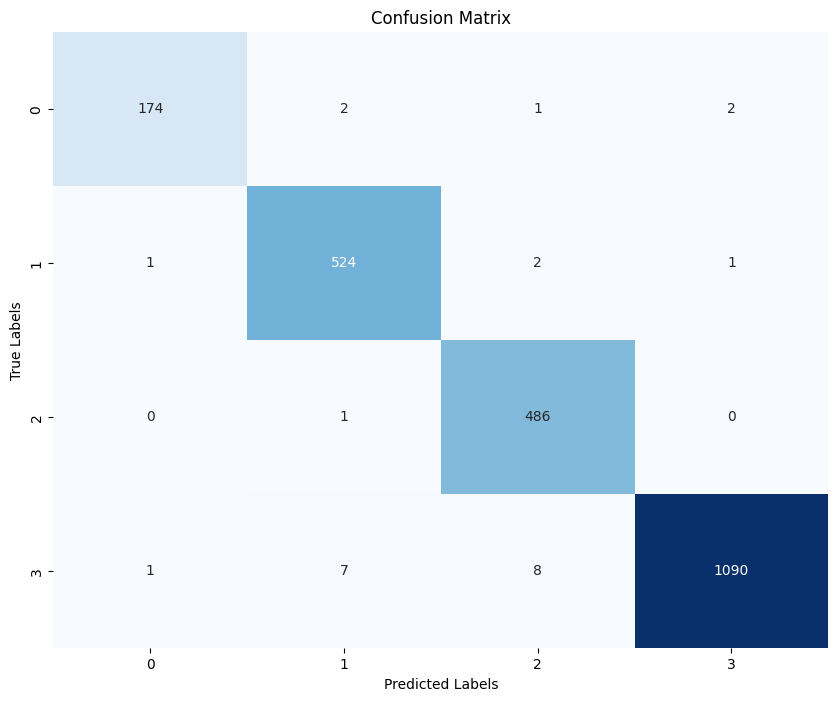

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace these with your actual test labels and predicted labels
# test_labels should be an array of true labels, and predicted_labels should be an array of model predictions
test_labels = el  # Replace with actual labels
predicted_labels = epl  # Replace with actual predictions

# Create the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
class_labels

['broadleaf', 'grass', 'soil', 'soybean']

In [ ]:
from tabulate import tabulate

# Generate classification report
report = classification_report(el, epl,
                              labels=np.arange(0, len(class_labels), 1),
                              target_names=class_labels,
                              digits=4, zero_division=0)

# Print classification report as a table
table = tabulate([x.split() for x in report.split('\n')[2:-5]],
                 headers=report.split('\n')[0].split(), tablefmt="fancy_grid")
print(table)

╒═══════════╤═════════════╤══════════╤════════════╤═══════════╕
│           │   precision │   recall │   f1-score │   support │
╞═══════════╪═════════════╪══════════╪════════════╪═══════════╡
│ broadleaf │      0.9886 │   0.9721 │     0.9803 │       179 │
├───────────┼─────────────┼──────────┼────────────┼───────────┤
│ grass     │      0.9813 │   0.9924 │     0.9868 │       528 │
├───────────┼─────────────┼──────────┼────────────┼───────────┤
│ soil      │      0.9779 │   0.9979 │     0.9878 │       487 │
├───────────┼─────────────┼──────────┼────────────┼───────────┤
│ soybean   │      0.9973 │   0.9855 │     0.9914 │      1106 │
╘═══════════╧═════════════╧══════════╧════════════╧═══════════╛


## Testing

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

72/72 [==============================] - 16s 225ms/step - loss: 0.0461 - accuracy: 0.9839
Test Loss: 0.046066246926784515
Test Accuracy: 0.9839270114898682


In [ ]:
tl, pl = [], []

for i in range(len(test_generator)):
  test_data, true_labels = next(test_generator)
  predicted_labels = model.predict(test_data)
  predicted_class_labels = np.argmax(predicted_labels, axis=-1)
  tl+=list(true_labels)
  pl+=list(predicted_class_labels)

tl = np.argmax(tl, axis=-1)

1/1 [==============================] - 0s 45ms/step


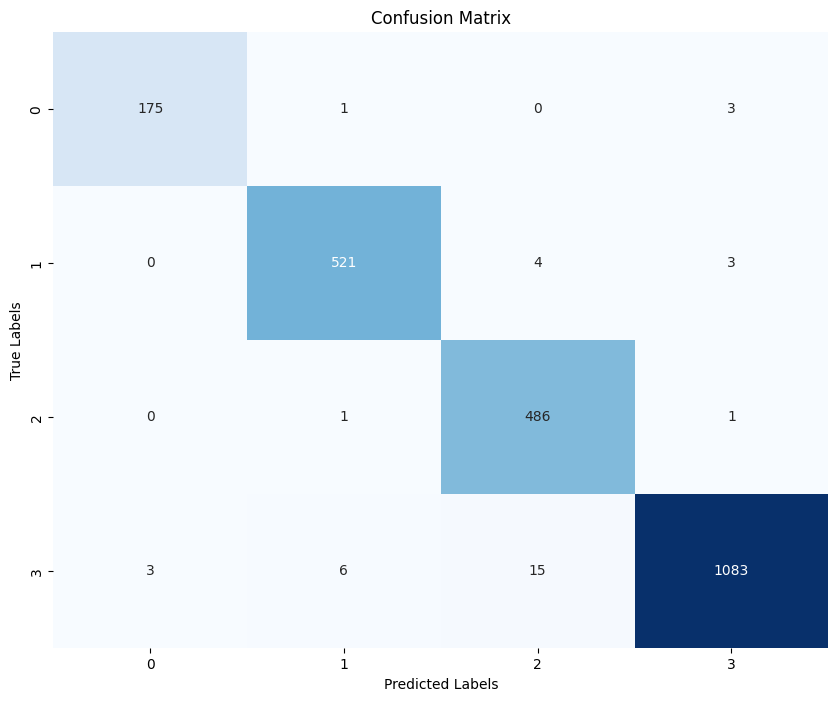

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace these with your actual test labels and predicted labels
# test_labels should be an array of true labels, and predicted_labels should be an array of model predictions
test_labels = tl  # Replace with actual labels
predicted_labels = pl  # Replace with actual predictions

# Create the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from tabulate import tabulate

# Generate classification report
report = classification_report(tl, pl,
                              labels=np.arange(0, len(class_labels), 1),
                              target_names=class_labels,
                              digits=4, zero_division=0)

# Print classification report as a table
table = tabulate([x.split() for x in report.split('\n')[2:-5]],
                 headers=report.split('\n')[0].split(), tablefmt="fancy_grid")
print(table)


╒═══════════╤═════════════╤══════════╤════════════╤═══════════╕
│           │   precision │   recall │   f1-score │   support │
╞═══════════╪═════════════╪══════════╪════════════╪═══════════╡
│ broadleaf │      0.9831 │   0.9777 │     0.9804 │       179 │
├───────────┼─────────────┼──────────┼────────────┼───────────┤
│ grass     │      0.9849 │   0.9867 │     0.9858 │       528 │
├───────────┼─────────────┼──────────┼────────────┼───────────┤
│ soil      │      0.9624 │   0.9959 │     0.9789 │       488 │
├───────────┼─────────────┼──────────┼────────────┼───────────┤
│ soybean   │      0.9936 │   0.9783 │     0.9859 │      1107 │
╘═══════════╧═════════════╧══════════╧════════════╧═══════════╛
